In [1]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm
from NN_Models import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-10-11 14:55:06.483101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
X_train = torch.load('data/X_sentence_train.pt')
# X_train = torch.load('data/X_doc2vec_train.pt')
y_train = torch.load('data/y_train.pt')

X_test = torch.load('data/X_sentence_test.pt')
# X_test = torch.load('data/X_doc2vec_test.pt')
y_test = torch.load('data/y_test.pt')

In [5]:
num_samples, num_features = X_train.shape

print(X_train.shape)
print(X_test.shape)

torch.Size([6268, 4999])
torch.Size([3086, 4999])


In [6]:
# train data loader
train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)

100%|██████████| 100/100 [30:36<00:00, 18.36s/it]


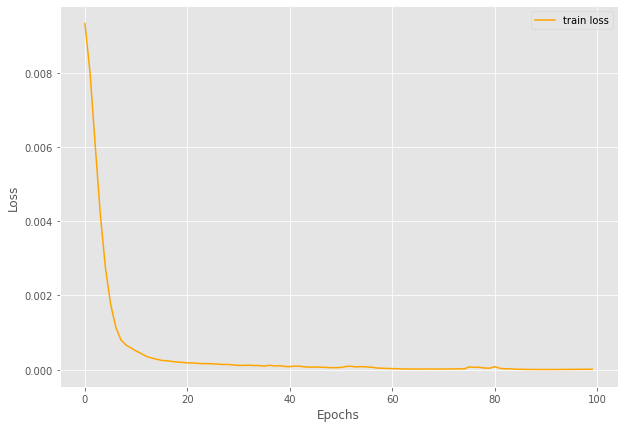

In [8]:
import torch.optim as optim

model = Model()
model.set_dim(num_features)
model.abstract_title()

learning_rate = 0.001
optimizer = optim.Adam(params=model.abstract_title().parameters(), lr=learning_rate) # 学习率衰减 / 学习率震荡
epochs = 100
model.train(train_dataloader, optimizer, epochs)
model.save_status("abstract_title")
model.plot_loss()

### Test (ignore when submit kaggle)

In [6]:
# m = Model()
# m.set_dim(num_features)
# model = m.abstract_title()
# model.load_state_dict(torch.load('status/abstract_title_doc2vec.pth'))

<All keys matched successfully>

In [10]:
from evaluation import evaluation

# print some info
print(f"[INFO]: Number of testing samples: {X_test.shape[0]}")
print(f"[INFO]: Number of testing features: {X_test.shape[1]}")

thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

f1_scores = evaluation(model.model, X_test, y_test, thresholds)
# f1_scores = evaluation(model, X_test, y_test, thresholds)

[INFO]: Number of testing samples: 3086
[INFO]: Number of testing features: 4999


100%|██████████| 9/9 [03:18<00:00, 22.06s/it]


In [11]:
print(thresholds[f1_scores.index(max(f1_scores))])
print(max(f1_scores))

0.2
0.32160015888733795


- 0.2
- 0.3264120187254715

In [13]:
from preprocessing import for_kaggle
from evaluation import kaggle_predict

# X_kaggle = for_kaggle('year_venue')

# kaggle_predict(model.model, X_train, 'abstract_title_train', lstm=True, num_features=num_features)
kaggle_predict(model.model, X_test, 'abstract_title_test', lstm=True, num_features=num_features)

100%|██████████| 3086/3086 [00:14<00:00, 218.54it/s]


# Kaggle Predictions

100%|██████████| 100/100 [47:41<00:00, 28.61s/it]


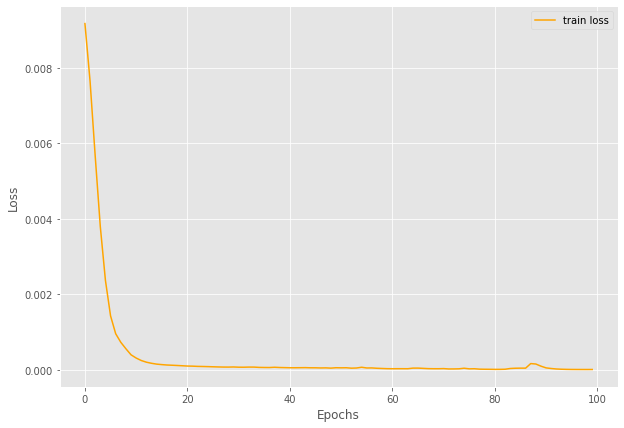

In [14]:
X_train = torch.load('data/X_sentence_all.pt')
# X_train = torch.load('data/X_doc2vec_kaggle')
y_train = torch.load('data/y_all.pt')
train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)

model = Model()
model.set_dim(num_features)
model.abstract_title()

learning_rate = 0.001
optimizer = optim.Adam(params=model.abstract_title().parameters(), lr=learning_rate) # 学习率衰减 / 学习率震荡
epochs = 100
model.train(train_dataloader, optimizer, epochs)
model.save_status("abstract_title")
model.plot_loss()

In [15]:
from preprocessing import for_kaggle
from evaluation import kaggle_predict

X_kaggle = for_kaggle('word')


kaggle_predict(model.model, X_train, 'abstract_title_all', lstm=True)
# kaggle_predict(model.model, X_kaggle, 'abstract_title_doc2vec', lstm=True)

100%|██████████| 9354/9354 [00:34<00:00, 273.94it/s]


In [ ]:
12

12